In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from google.colab import files


import pandas as pd
import numpy as np
from torchvision import transforms

In [2]:
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

print("Upload your TRAIN CSV file:")
uploaded_train = files.upload()
train_file = list(uploaded_train.keys())[0]
train_df = pd.read_csv(train_file)

print("\nUpload your TEST CSV file:")
uploaded_test = files.upload()
test_file = list(uploaded_test.keys())[0]
test_df = pd.read_csv(test_file)

print("Train shape:", train_df.shape) #rows and coloumns of this dataset
print("Test shape:", test_df.shape)


Upload your TRAIN CSV file:


Saving sign_mnist_train.csv to sign_mnist_train.csv

Upload your TEST CSV file:


Saving sign_mnist_test.csv to sign_mnist_test.csv
Train shape: (27455, 785)
Test shape: (7172, 785)


In [ ]:

from torch.utils.data import DataLoader, TensorDataset

X_train = train_df.drop('label', axis=1).values.astype('float32').reshape(-1, 1, 28, 28)
y_train = train_df['label'].values.astype('int64')

X_test  = test_df.drop('label', axis=1).values.astype('float32').reshape(-1, 1, 28, 28)
y_test  = test_df['label'].values.astype('int64')


X_train = torch.tensor(X_train) / 255.0  # scale 0-1
y_train = torch.tensor(y_train)

X_test  = torch.tensor(X_test) / 255.0
y_test  = torch.tensor(y_test)


mean, std = 0.5, 0.5
X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std


train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)



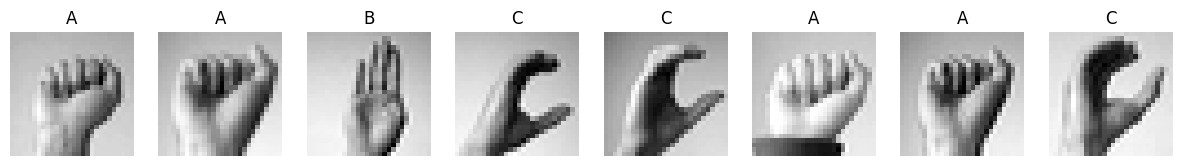

In [5]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

images = images * 0.5 + 0.5

fig, axes = plt.subplots(1, 8, figsize=(15,2))
label_map = {0:'A', 1:'B', 2:'C'}

for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"{label_map[labels[i].item()]}")
    axes[i].axis('off')

plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 3)   # only 3 classes
        self.relu  = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = CNN().to(DEVICE)
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [8]:
train_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.4f}")


Epoch 1/10 — Loss: 0.2154
Epoch 2/10 — Loss: 0.0006
Epoch 3/10 — Loss: 0.0002
Epoch 4/10 — Loss: 0.0002
Epoch 5/10 — Loss: 0.0001
Epoch 6/10 — Loss: 0.0001
Epoch 7/10 — Loss: 0.0001
Epoch 8/10 — Loss: 0.0001
Epoch 9/10 — Loss: 0.0001
Epoch 10/10 — Loss: 0.0000


In [9]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        total += lbls.size(0)
        correct += (preds == lbls).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


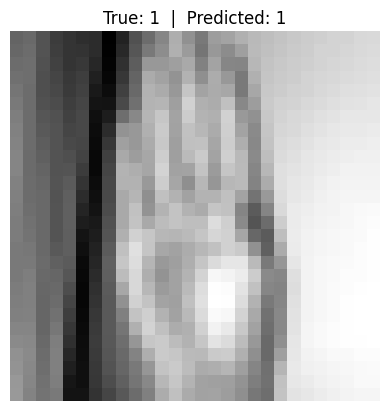

In [10]:
imgs, lbls = next(iter(test_loader))
imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
model.eval()
with torch.no_grad():
    outputs = model(imgs)
_, preds = torch.max(outputs, 1)

i = 5
plt.imshow(imgs[i].cpu().squeeze(), cmap="gray")
plt.title(f"True: {lbls[i].item()}  |  Predicted: {preds[i].item()}")
plt.axis("off")
plt.show()

In [11]:
torch.save(model.state_dict(), "sign_language_cnn.pth")
files.download("sign_language_cnn.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>